In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import lightgbm as lgb
import joblib
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import datetime
from tqdm import tqdm
from joblib import Parallel, delayed

In [5]:
items = pd.read_csv("data/input/items.csv")
categories = pd.read_csv("data/input/item_categories.csv")
shops = pd.read_csv("data/input/shops.csv")
train = pd.read_csv("data/input/sales_train.csv")
test = pd.read_csv("data/input/test.csv")

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10


shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_id'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_id']]

categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x: x[0].strip())
categories['type_id'] = LabelEncoder().fit_transform(categories['type'])
# if subtype is nan then type
categories['subtype'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subtype_id'] = LabelEncoder().fit_transform(categories['subtype'])
categories = categories[['item_category_id','type_id', 'subtype_id']]

items.drop(['item_name'], axis=1, inplace=True)

test = test.merge(items, on="item_id", how="left")
train = train.merge(items, on="item_id", how="left")
train = train.merge(categories, on="item_category_id", how="left")
test = test.merge(categories, on="item_category_id", how="left")
train = train.merge(shops, on="shop_id", how="left")
test = test.merge(shops, on="shop_id", how="left")

In [7]:
# some statistics of the target
def apply_parallel(dfgroup, func, n_jobs=4, **kwargs):
    results = Parallel(n_jobs=n_jobs)(delayed(func)(group, **kwargs) for name, group in tqdm(dfgroup))
    return pd.concat(results)

def remove_outliers(df):
    # q = df["item_cnt_day"].quantile(0.999)
    # df = df[(df["item_cnt_day"]<=q)].copy()
    df.loc[:, "date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
    return df

def get_cartesian_product(train):
    res = []
    cols = ["shop_id", "item_id", "date_block_num"]
    for i in range(34):
        data = train[train["date_block_num"]==i]
        res.append(np.array(list(itertools.product(data["shop_id"].unique(), data["item_id"].unique(), [i])), dtype="int16"))
    res = pd.DataFrame(np.vstack(res), columns=cols)
    res.sort_values(cols, inplace=True)
    return res

def get_label(df):
    return df.groupby(["shop_id", "item_id", "date_block_num"], as_index=False)[["item_cnt_day"]].\
                                aggregate(item_cnt_month=("item_cnt_day", "sum"))
                                                           
def get_feature_header(prod, labels, items):
    feature = prod.merge(items[["item_id", "item_category_id"]])
    feature = feature.merge(labels, on=["shop_id","item_id","date_block_num"], how="left")
    return feature

def rolling_shop_item_sales(input, lags):
    for lag in lags:
        if lag > 1:
            rolling = input["item_cnt_month"].rolling(lag).mean()
            input["rolling"+str(lag)+"_shop_item_sales"] = rolling
    input.drop(["item_cnt_month", "item_category_id"], axis=1, inplace=True)
    return input
def price_shop_item(input):
    price_df = input[input.item_cnt_month>0]
    price_df["price_delta"] = price_df["item_price"].diff(1) / price_df["item_price"]
    return price_df

In [8]:
train = remove_outliers(train)
prod = get_cartesian_product(train)
labels = get_label(train)
train_header = get_feature_header(prod, labels, items)
# price_diff = apply_parallel(train_header.groupby(["shop_id", "item_id"]), price_shop_item)
# train_header = train_header.merge(price_diff[["shop_id", "item_id", "date_block_num", "price_delta"]], on=["shop_id", "item_id", "date_block_num"], how="left")
train_header["item_cnt_month"] = train_header["item_cnt_month"].clip(0, 20)
train_header = train_header.merge(categories, on="item_category_id")
train_header = train_header.merge(shops, on="shop_id")

shop_item_rolling = apply_parallel(train_header.groupby(["shop_id", "item_id"]), rolling_shop_item_sales, lags = [2, 3, 6])

In [13]:
train.to_csv("data/train.csv", index=False)
test.to_csv("data/test.csv", index=False)
train_header.to_csv("data/train_header.csv", index=False)
# price_diff.to_csv("data/price_diff.csv", index=False)
shop_item_rolling.to_csv("data/shop_item_rolling.csv", index=False)

## Stage 2

In [7]:
# train = pd.read_csv("data/sales_train.csv")
# test = pd.read_csv("data/test.csv")
# train_header = pd.read_csv("data/train_header.csv")
shop_item_rolling = pd.read_csv("data/shop_item_rolling.csv")

In [16]:
# mean encoding
def mean_encoding(df, source, shop_item_rolling, lags):
     # first order feature
     date_shop_sales = source.groupby(["shop_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_shop_sales"}, axis=1).reset_index()
     date_item_sales = source.groupby(["item_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_item_sales"}, axis=1).reset_index()
     date_cat_sales = source.groupby(["item_category_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_cat_sales"}, axis=1).reset_index()
     date_city_sales = source.groupby(["city_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_city_sales"}, axis=1).reset_index()
     date_type_sales = source.groupby(["type_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_type_sales"}, axis=1).reset_index()
     date_subtype_sales = source.groupby(["subtype_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_subtype_sales"}, axis=1).reset_index()
     # second order interaction     
     date_shop_cat_sales = source.groupby(["shop_id", "item_category_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_shop_cat_sales"}, axis=1).reset_index()
     date_city_cat_sales = source.groupby(["city_id", "item_category_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_city_cat_sales"}, axis=1).reset_index()
     date_city_item_sales = source.groupby(["city_id", "item_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_city_item_sales"}, axis=1).reset_index()
     date_shop_type_sales = source.groupby(["shop_id", "type_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_shop_type_sales"}, axis=1).reset_index()
     date_shop_subtype_sales = source.groupby(["shop_id", "subtype_id", "date_block_num"])["item_cnt_month"].agg({"mean"}).\
               rename({"mean":"date_shop_subtype_sales"}, axis=1).reset_index()
     for lag in lags:
          date_shop_item_sales = source[["shop_id", "item_id", "date_block_num", "item_cnt_month"]].copy()
          date_shop_item_sales.loc[:, "date_block_num"] += lag
          date_shop_item_sales.rename({"item_cnt_month":"date_shop_item_sales"}, axis=1, inplace=True)
          date_shop_cat_sales.loc[:, "date_block_num"] += lag
          date_shop_sales.loc[:, "date_block_num"] += lag
          date_item_sales.loc[:, "date_block_num"] += lag
          date_cat_sales.loc[:, "date_block_num"] += lag
          date_city_sales.loc[:, "date_block_num"] += lag
          date_type_sales.loc[:, "date_block_num"] += lag
          date_subtype_sales.loc[:, "date_block_num"] += lag
          date_city_cat_sales.loc[:, "date_block_num"] += lag
          date_city_item_sales.loc[:, "date_block_num"] += lag
          date_shop_type_sales.loc[:, "date_block_num"] += lag
          date_shop_subtype_sales.loc[:, "date_block_num"] += lag
          
          df = df.merge(date_shop_item_sales, on=["shop_id", "item_id", "date_block_num"], how="left")
          df = df.merge(date_shop_cat_sales, on=["shop_id", "item_category_id", "date_block_num"], how="left")
          df = df.merge(date_shop_sales, on=["shop_id", "date_block_num"], how="left")
          df = df.merge(date_item_sales, on=["item_id", "date_block_num"], how="left")
          df = df.merge(date_cat_sales, on=["item_category_id", "date_block_num"], how="left")
          df = df.merge(date_city_sales, on=["city_id", "date_block_num"], how="left")
          df = df.merge(date_type_sales, on=["type_id", "date_block_num"], how="left")
          df = df.merge(date_subtype_sales, on=["subtype_id", "date_block_num"], how="left")
          df = df.merge(date_city_cat_sales, on=["city_id", "item_category_id", "date_block_num"], how="left")
          df = df.merge(date_city_item_sales, on=["city_id", "item_id", "date_block_num"], how="left")
          df = df.merge(date_shop_type_sales, on=["shop_id", "type_id", "date_block_num"], how="left")
          df = df.merge(date_shop_subtype_sales, on=["shop_id", "subtype_id", "date_block_num"], how="left")
          
          df.rename({"date_shop_item_sales":"lag"+str(lag)+"_shop_item_sales", "date_shop_cat_sales":"lag"+str(lag)+"_shop_cat_sales",
                  "date_shop_sales":"lag"+str(lag)+"_shop_sales", "date_item_sales":"lag"+str(lag)+"_item_sales",
                  "date_cat_sales":"lag"+str(lag)+"_cat_sales", "date_city_sales":"lag"+str(lag)+"_city_sales",
                  "date_type_sales":"lag"+str(lag)+"_type_sales", "date_subtype_sales":"lag"+str(lag)+"_subtype_sales",
                  "date_shop_type_sales":"lag"+str(lag)+"_shop_type_sales","date_shop_subtype_sales":"lag"+str(lag)+"_shop_subtype_sales",
                  "date_city_cat_sales":"lag"+str(lag)+"_city_cat_sales", "date_city_item_sales":"lag"+str(lag)+"_city_item_sales"}, axis=1, inplace=True)
               
     
          date_shop_cat_sales.loc[:, "date_block_num"] -= lag
          date_shop_sales.loc[:, "date_block_num"] -= lag
          date_item_sales.loc[:, "date_block_num"] -= lag
          date_cat_sales.loc[:, "date_block_num"] -= lag
          date_city_sales.loc[:, "date_block_num"] -= lag
          date_type_sales.loc[:, "date_block_num"] -= lag
          date_subtype_sales.loc[:, "date_block_num"] -= lag
          date_city_cat_sales.loc[:, "date_block_num"] -= lag
          date_city_item_sales.loc[:, "date_block_num"] -= lag
          date_shop_type_sales.loc[:, "date_block_num"] -= lag
          date_shop_subtype_sales.loc[:, "date_block_num"] -= lag
     
     # rolling features
     shop_item_rolling.loc[:, "date_block_num"] += 1
     df = df.merge(shop_item_rolling.drop(["type_id", "subtype_id", "city_id"], axis=1), on=["shop_id", "item_id", "date_block_num"], how="left")
     shop_item_rolling.loc[:, "date_block_num"] -= 1
         
     # special features
     df["month_of_year_sin"] = np.sin(2 * np.pi * df["date_block_num"]/12)
     df["month_of_year_cos"] = np.cos(2 * np.pi * df["date_block_num"]/12)
     df["month_of_year_sin"] = df["month_of_year_sin"].round(3)
     df["month_of_year_cos"] = df["month_of_year_cos"].round(3)
     df["shop_item_first_sale"] = df["date_block_num"] - source.groupby(["shop_id", "item_id"])["date_block_num"].transform("min")
     df["item_first_sale"] = df["date_block_num"] - source.groupby(["item_id"])["date_block_num"].transform("min")
     return df

In [17]:
feature = mean_encoding(train_header, train_header, shop_item_rolling, [1, 2, 3, 6])
test["date_block_num"] = 34
feature_test = mean_encoding(test, train_header,shop_item_rolling, [1, 2, 3, 6])

In [34]:
feature_train = feature[feature["date_block_num"]>=12]
X_train, X_dev = feature_train[feature_train["date_block_num"]<=32].drop(["item_cnt_month", "date_block_num"], axis=1).fillna(0).iloc[:, 6:],\
                feature_train[feature_train["date_block_num"]>32].drop(["item_cnt_month", "date_block_num"], axis=1).fillna(0).iloc[:, 6:]
y_train, y_dev = feature_train.loc[feature_train["date_block_num"]<=32, "item_cnt_month"],\
    feature.loc[feature["date_block_num"]>32, "item_cnt_month"]
y_train = y_train.apply(lambda x: 0 if not x else x).fillna(0)
y_dev = y_dev.apply(lambda x: 0 if not x else x).fillna(0)
X_test = feature_test.drop("date_block_num", axis=1).iloc[:, 7:].fillna(0)

In [53]:
early_stop = lgb.callback.early_stopping(10)
model = lgb.LGBMRegressor(num_leaves=15, max_depth=4, learning_rate=0.1, subsample=0.5, colsample_bytree=0.5,
                            min_child_weight=3000, reg_alpha=1.5, reg_lambda=1.5, n_estimators=1000, random_state=42)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_dev, y_dev)], eval_metric="rmse", callbacks=[early_stop])
        #   categorical_feature=["shop_id", "item_id", "item_category_id", "city_id", "type_id", "subtype_id"])

[1]	training's rmse: 1.14577	training's l2: 1.31279	valid_1's rmse: 1.10714	valid_1's l2: 1.22576
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.1098	training's l2: 1.23165	valid_1's rmse: 1.08215	valid_1's l2: 1.17105
[3]	training's rmse: 1.08264	training's l2: 1.17211	valid_1's rmse: 1.06377	valid_1's l2: 1.1316
[4]	training's rmse: 1.05722	training's l2: 1.11771	valid_1's rmse: 1.04578	valid_1's l2: 1.09366
[5]	training's rmse: 1.03147	training's l2: 1.06392	valid_1's rmse: 1.02876	valid_1's l2: 1.05835
[6]	training's rmse: 1.01296	training's l2: 1.0261	valid_1's rmse: 1.01551	valid_1's l2: 1.03126
[7]	training's rmse: 0.997226	training's l2: 0.994459	valid_1's rmse: 1.00521	valid_1's l2: 1.01045
[8]	training's rmse: 0.979798	training's l2: 0.960005	valid_1's rmse: 0.993917	valid_1's l2: 0.987871
[9]	training's rmse: 0.965177	training's l2: 0.931567	valid_1's rmse: 0.984947	valid_1's l2: 0.97012
[10]	training's rmse: 0.954005	training's l2: 0.910

LGBMRegressor(colsample_bytree=0.5, max_depth=4, min_child_samples=1000,
              min_child_weight=3000, n_estimators=1000, num_leaves=15,
              random_state=42, reg_alpha=1.5, reg_lambda=1.5, subsample=0.5)

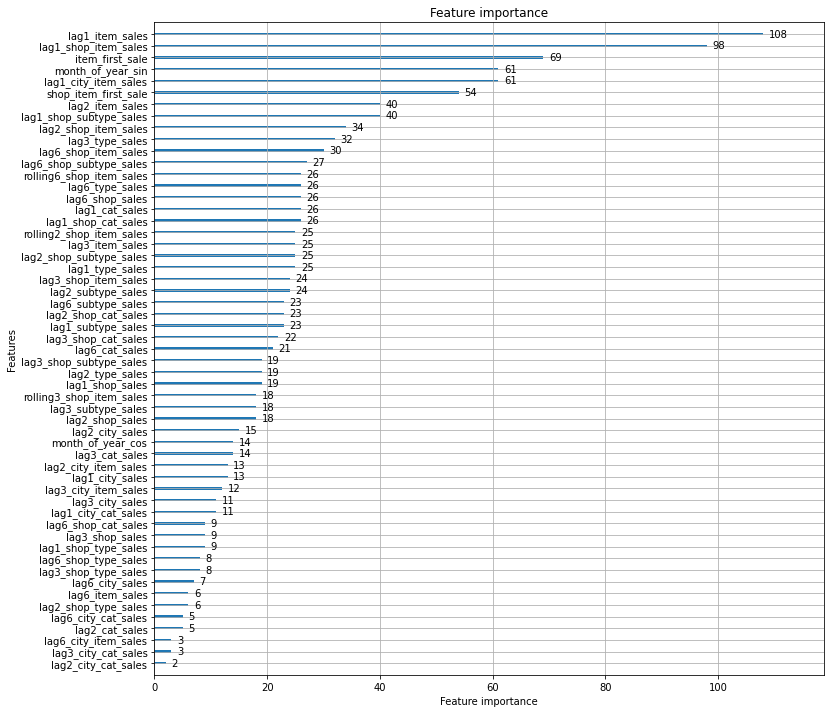

In [54]:
lgb.plot_importance(model, figsize=(12, 12))
plt.show()

In [50]:
joblib.dump(model, "model/lgb_lb_1.0001.pkl")
joblib.dump(feature, "data/lb_1.0001_feature.pkl")
joblib.dump(feature_test, "data/lb_1.001_feature_test.pkl")

['data/lb_1.001_feature_test.pkl']

In [45]:
pred = model.predict(X_test, num_iteration=model.best_iteration_)
pred = np.clip(pred, 0, 20)
submission = pd.DataFrame({"item_cnt_month":pred}).reset_index().rename({"index":"ID"}, axis=1)
submission.to_csv("data/submission_model_" + str(datetime.datetime.now().date()) + ".csv", index=False)

In [27]:
# previous value benchmark
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
prev = train[(train["date"].dt.year==2015)&(train["date"].dt.month==10)]
prev_agg = prev.groupby(["shop_id", "item_id"], as_index=False)[["item_cnt_day"]].aggregate(item_cnt_month=("item_cnt_day", "sum"))
prev_benchmark = test.merge(prev_agg, on=["shop_id", "item_id"], how="left")
prev_benchmark = prev_benchmark[["ID", "item_cnt_month"]].fillna(0)
prev_benchmark["item_cnt_month"] = np.clip(prev_benchmark["item_cnt_month"], 0, 20)
prev_benchmark.to_csv("data/submission_prev_value.csv", index=False)

In [31]:
comp = pd.DataFrame({"ID":prev_benchmark.ID, "a":X_test["lag1_shop_item_sales"], "b":prev_benchmark["item_cnt_month"]})
comp["indicator"] = comp.apply(lambda x: 1 if x["a"]!=x["b"] else 0, axis=1)

In [26]:
submission.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.229559
std,61834.358168,0.682413
min,0.000000,0.000000
25%,53549.750000,0.025480
50%,107099.500000,0.076989
75%,160649.250000,0.207321
max,214199.000000,20.000000


In [56]:
feature.to_csv("data/feature.csv", index=False)
feature_test.to_csv("data/feature_test.csv", index=False)

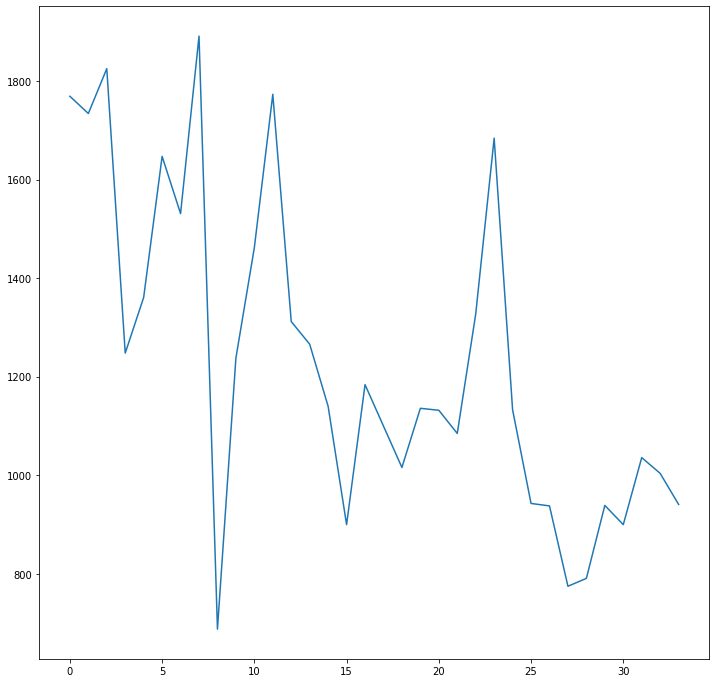

In [69]:
_, ax = plt.subplots(1, 1, figsize=(12, 12))
data = feature[feature.shop_id==14].groupby("date_block_num")["item_cnt_month"].agg("sum")
ax.plot(data)

In [70]:
data

date_block_num
0     1769.0
1     1734.0
2     1825.0
3     1248.0
4     1361.0
5     1647.0
6     1531.0
7     1891.0
8      688.0
9     1238.0
10    1462.0
11    1773.0
12    1312.0
13    1266.0
14    1140.0
15     900.0
16    1184.0
17    1100.0
18    1016.0
19    1136.0
20    1132.0
21    1085.0
22    1327.0
23    1684.0
24    1133.0
25     943.0
26     938.0
27     775.0
28     791.0
29     939.0
30     900.0
31    1036.0
32    1004.0
33     941.0
Name: item_cnt_month, dtype: float64